1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами:
    1. одна модель с признаком коммуникации (S-learner)
    2. модель с трансформацией таргета
    3. вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

from google.colab import files

files.upload()

In [ ]:
!pip install scikit-uplift catboost

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier

In [ ]:
df = pd.read_csv('data.csv')
df_model = df.copy()
df_model.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [ ]:
df_model.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)

In [ ]:
df_model['treatment'] = np.where(df_model['treatment'] == 'No Offer', 0, 1).astype('i1')

In [ ]:
df_model.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [ ]:
df_model['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [ ]:
df_model['target'].value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(df_model.drop(columns=['target']), 
                                                            df_model['target'],
                                                            df_model['treatment'],
                                                            random_state=23)

In [ ]:
del X_train['treatment']

In [ ]:
X_train

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
131,7,185.73,1,0,Surburban,0,Phone
50547,5,536.22,1,0,Surburban,1,Phone
23459,3,191.18,0,1,Urban,1,Web
22868,6,139.25,1,0,Urban,0,Web
36441,2,161.45,0,1,Surburban,1,Web
...,...,...,...,...,...,...,...
11190,9,165.53,1,0,Urban,0,Web
26569,10,55.37,1,0,Surburban,0,Phone
9256,3,330.00,0,1,Rural,1,Web
62182,11,124.46,0,1,Surburban,0,Web


In [ ]:
del X_test['treatment']

In [ ]:
X_test

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
44433,10,156.04,0,1,Urban,1,Phone
44668,7,76.65,1,0,Surburban,1,Web
47303,1,231.76,1,1,Surburban,0,Phone
23627,1,29.99,1,0,Urban,0,Web
14419,10,447.45,0,1,Urban,1,Multichannel
...,...,...,...,...,...,...,...
33893,3,382.64,1,0,Surburban,0,Phone
1530,6,196.12,0,1,Surburban,0,Phone
8575,8,140.84,1,0,Surburban,0,Phone
49821,3,400.19,1,0,Rural,1,Phone


In [ ]:
cat_features = ['zip_code', 'channel']
models_results = {'approach': [], 'uplift@10%': [], 'uplift@20%': []}

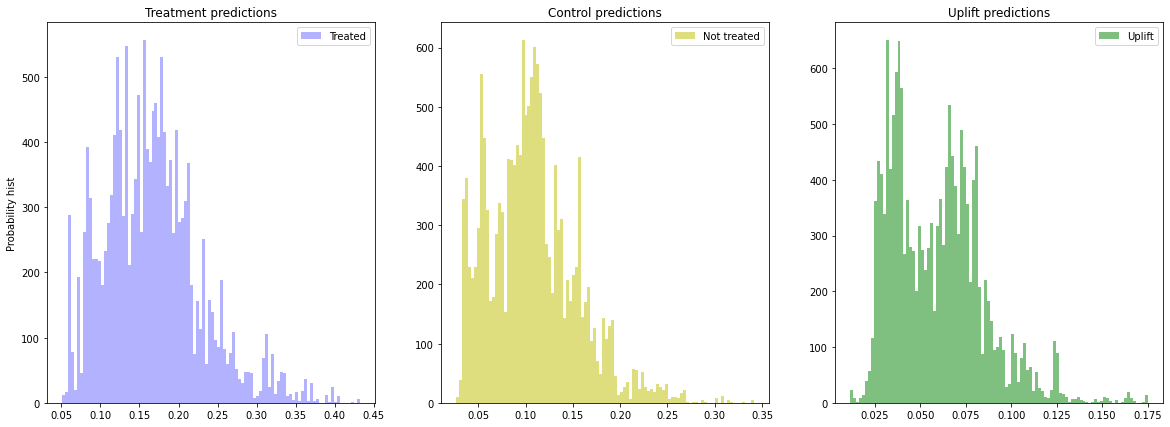

In [ ]:
sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=23, silent=True, cat_features=cat_features)
)

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [ ]:
ct = ClassTransformation(
    CatBoostClassifier(iterations=20, random_state=23, silent=True, cat_features=cat_features)
)
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)


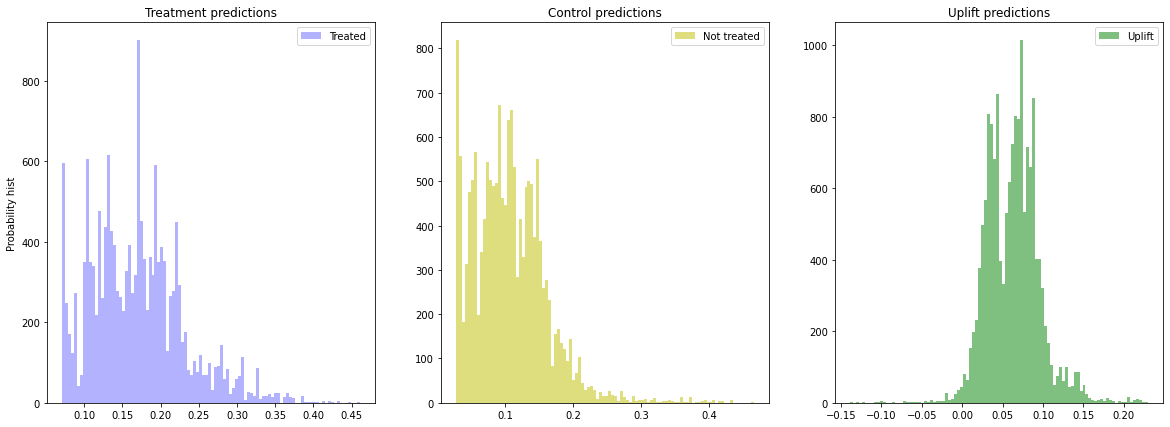

In [ ]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=23, silent=True, cat_features=cat_features),
    CatBoostClassifier(iterations=20, random_state=23, silent=True, cat_features=cat_features),
    method='vanilla'
)
tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

tm_trmnt_preds = tm.trmnt_preds_
tm_ctrl_preds = tm.ctrl_preds_

plot_uplift_preds(trmnt_preds=tm_trmnt_preds, ctrl_preds=tm_ctrl_preds);

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.096882,0.070642
2,TwoModels,0.080410,0.076825
0,SoloModel,0.069862,0.073125


Solo Model


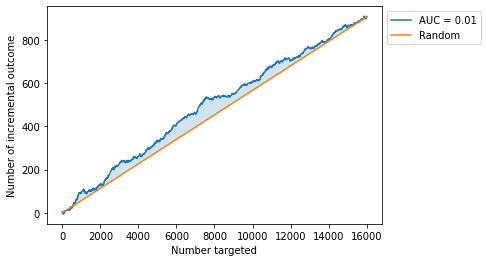

ClassTransform Model


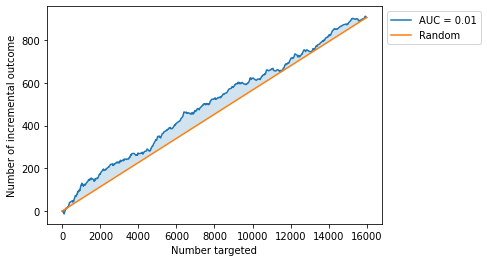

Two Model


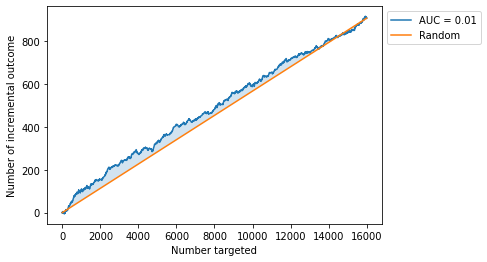

In [ ]:
from sklift.viz import plot_uplift_curve
import matplotlib.pyplot as plt

print('Solo Model')
plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=False)
plt.show()
print('ClassTransform Model')
plot_uplift_curve(y_test, uplift_ct, treat_test, perfect=False)
plt.show()
print('Two Model')
plot_uplift_curve(y_test, uplift_tm, treat_test, perfect=False)
plt.show()